In [1]:
import numpy as np
import matplotlib.pyplot as plt
import colorsys

# retro engineering of the high tones DxO Selective tones setting

After notebooks from checkerboard and greys, we will implemant the high tone setting in DxO Selective Tones. (A similar process can be done for middle, shadow and black tones)

## High tones 100 on easy image

First we will try for an easy image which is only with grey levels:
To do this, for each pixel of the input image we extract the lightness, we apply bezier model we found in greys.ipynb, and we create a new images from this new lightness (and we keep the hue and saturation)

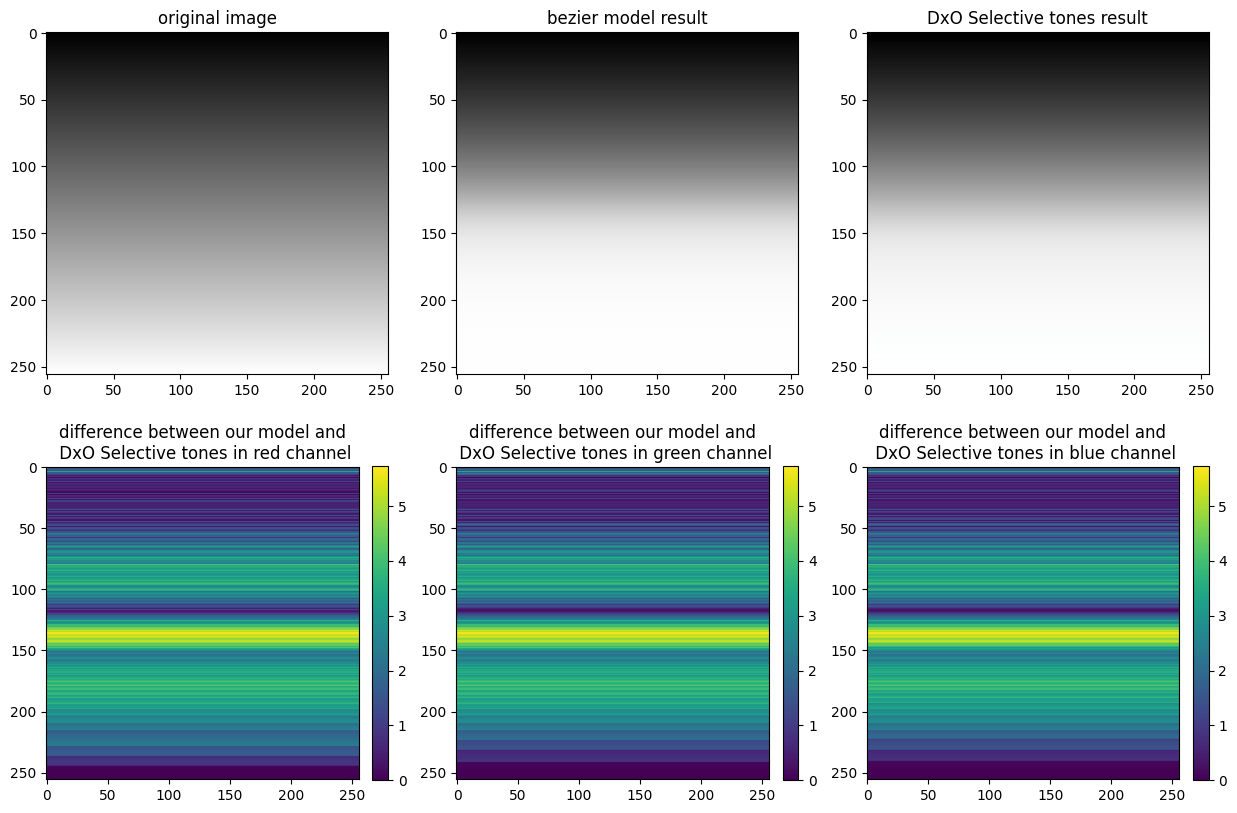

In [2]:
def bezier_curve(t, p0, p1, p2, p3):
    t = (np.array(t)-min(t))/(max(t)-min(t))
    x0, y0, x1, y1, x2, y2, x3, y3 = p0[0], p0[1], p1[0], p1[1], p2[0], p2[1], p3[0], p3[1]
    x = (((1 - t) * ((1 - t) * ((1 - t) * x0 + t * x1) + t * ((1 - t) * x1 + t * x2)) +  t * ((1 - t) * ((1 - t) * x1 + t * x2) + t * ((1 - t) * x2 + t * x3))))
    y = (((1 - t) * ((1 - t) * ((1 - t) * y0 + t * y1) + t * ((1 - t) * y1 + t * y2)) + t * ((1 - t) * ((1 - t) * y1 + t * y2) + t * ((1 - t) * y2 + t * y3))))
    return x * 255, y * 255

def apply_high_tones(image, scale):
    "scale must be between -100 and 100, pixels must be between 0 et 255"
    h, lightness, s = np.zeros((image.shape[0], image.shape[1])), np.zeros((image.shape[0], image.shape[1])), np.zeros((image.shape[0], image.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            h[i, j], lightness[i,j], s[i, j] = colorsys.rgb_to_hls(image[i, j, 0]/255, image[i, j, 1]/255, image[i, j, 2]/255)
            
            lightness[i, j] *= 255
    #define the model according to scale
    scale /=100
    coeff = (((1+scale)/2)*0.3 + ((1-scale)/2)*0.95, ((1+scale)/2)*1 + ((1-scale)/2)*0.3)
    x = np.linspace(0, 1, 256)
    X_pred, Y_pred = bezier_curve(x, (1., 1.), coeff, (0.75, 0.75), (0., 0.))
    
    new_lightness = np.zeros((image.shape[0], image.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # find idx where X is closest to lightness[i, j]
            idx = (np.abs(X_pred-lightness[i, j])).argmin()
            new_lightness[i, j] = Y_pred[idx]
    
    # apply the new lightness to the image
    new_image = np.zeros((image.shape[0], image.shape[1], 3))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_image[i, j] = colorsys.hls_to_rgb(h[i, j], new_lightness[i, j]/255, s[i, j])
    return new_image

original_greys = plt.imread("grey_levels.tif")
new_im = apply_high_tones(original_greys, 100)
# plot the images on the same figure
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(original_greys)
plt.title("original image")

plt.subplot(2, 3, 2)
plt.imshow(new_im)
plt.title("bezier model result")

plt.subplot(2, 3, 3)
real = plt.imread("grey_levels_high_100.tif")
plt.imshow(real)
plt.title("DxO Selective tones result")

difference = np.abs(new_im*255 - real)

plt.subplot(2, 3, 4)
im = plt.imshow(difference[:,:,0])
plt.title("difference between our model and\n DxO Selective tones in red channel")
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(2, 3, 5)
im1 = plt.imshow(difference[:,:,1])
plt.title("difference between our model and\n DxO Selective tones in green channel")
plt.colorbar(im1,fraction=0.046, pad=0.04)

plt.subplot(2, 3, 6)
im2 = plt.imshow(difference[:,:,2])
plt.title("difference between our model and\n DxO Selective tones in blue channel")
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.show()

As we can see, the model works well for greys level as the maximum difference in each channel (r,g,b) is 5 

## High tones 100 on real image

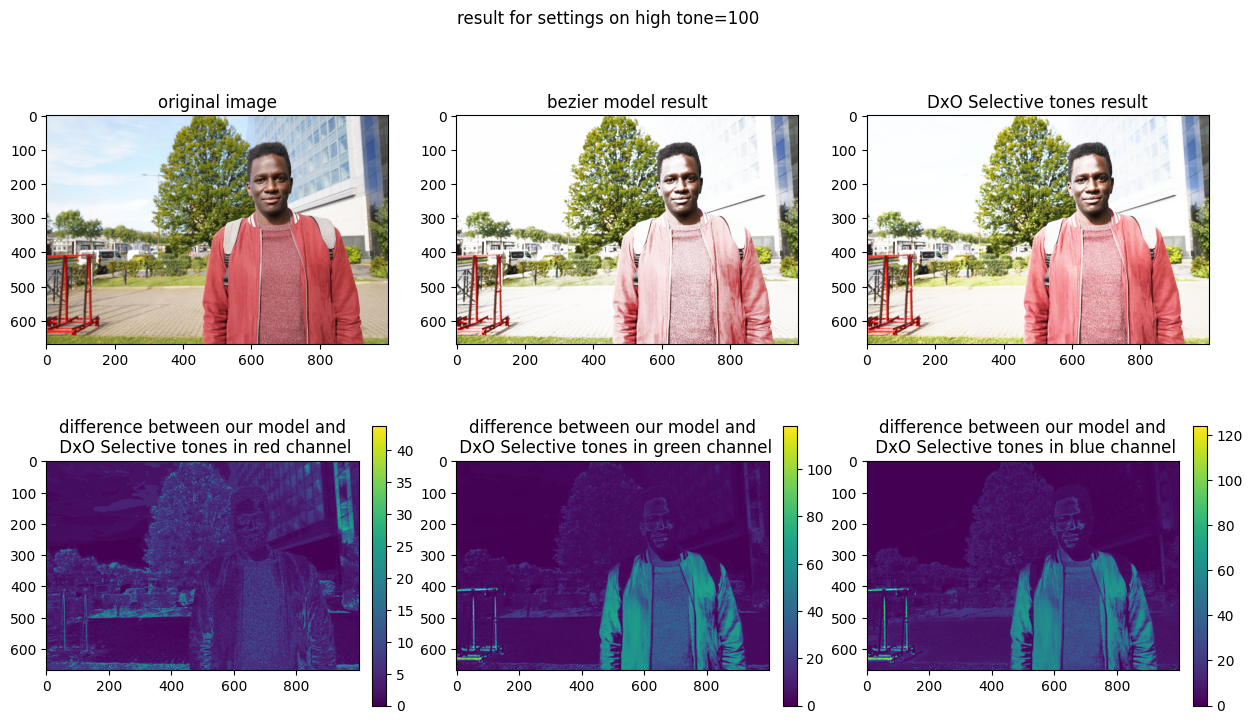

In [7]:
# plot the images on the same figure
plt.figure(figsize=(15, 8))
plt.suptitle("result for settings on high tone=100")

funny_image = plt.imread("steve_jobs.jpeg")
new_im = apply_high_tones(funny_image, 100)

plt.subplot(2, 3, 1)
plt.imshow(funny_image)
plt.title("original image")

plt.subplot(2, 3, 2)
plt.imshow(new_im)
plt.title("bezier model result")

plt.subplot(2, 3, 3)
real = plt.imread("steve_jobs_high_100.tif")
plt.imshow(real)
plt.title("DxO Selective tones result")

difference = np.abs(new_im*255 - real)

plt.subplot(2, 3, 4)
im = plt.imshow(difference[:,:,0])
plt.title("difference between our model and\n DxO Selective tones in red channel")
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(2, 3, 5)
im1 = plt.imshow(difference[:,:,1])
plt.title("difference between our model and\n DxO Selective tones in green channel")
plt.colorbar(im1,fraction=0.046, pad=0.04)

plt.subplot(2, 3, 6)
im2 = plt.imshow(difference[:,:,2])
plt.title("difference between our model and\n DxO Selective tones in blue channel")
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.show()

As we can see, our model is not perfect, espacially on pixels which are not grey level (example : the face of steve jobs) which seems to mean that the real model is not based solely on lightness, but also unequally between the red, green and blue channels.

## High tones -50 on real image

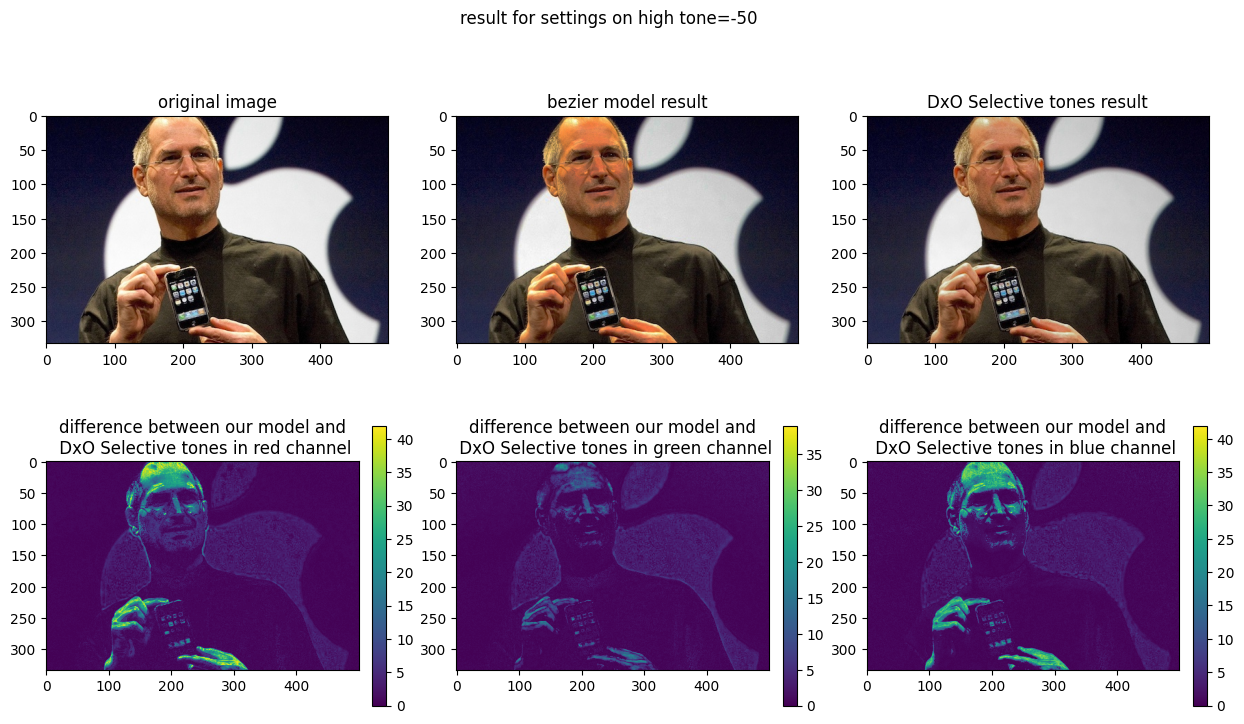

In [6]:
# plot the images on the same figure
plt.figure(figsize=(15, 8))
plt.suptitle("result for settings on high tone=-50")

funny_image = plt.imread("steve_jobs.jpeg")
new_im = apply_high_tones(funny_image, -50)

plt.subplot(2, 3, 1)
plt.imshow(funny_image)
plt.title("original image")

plt.subplot(2, 3, 2)
plt.imshow(new_im)
plt.title("bezier model result")

plt.subplot(2, 3, 3)
real = plt.imread("steve_jobs_high_-50.tif")
plt.imshow(real)
plt.title("DxO Selective tones result")

difference = np.abs(new_im*255 - real)

plt.subplot(2, 3, 4)
im = plt.imshow(difference[:,:,0])
plt.title("difference between our model and\n DxO Selective tones in red channel")
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(2, 3, 5)
im1 = plt.imshow(difference[:,:,1])
plt.title("difference between our model and\n DxO Selective tones in green channel")
plt.colorbar(im1,fraction=0.046, pad=0.04)

plt.subplot(2, 3, 6)
im2 = plt.imshow(difference[:,:,2])
plt.title("difference between our model and\n DxO Selective tones in blue channel")
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.show()

Once again, we see the same thing: the model matches reality on shades of grey but not on pixels that are not shades of grey.